# Gray to BGR

In this notebook, we would like to discuss how OpenCV does its
```python
bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
```

## Hypothesis 1

> "_It is nothing fancier than just repeating the single-channel grayscale image 3 times._"

Let's verify this.

In [1]:
import sys

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

plt.style.use("dark_background")
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [2]:
print(f"{sys.version            = }")
print(f"{cv2.__version__        = }")
print(f"{matplotlib.__version__ = }")
print(f"{np.__version__         = }")

sys.version            = '3.10.4 (main, Mar 31 2022, 03:38:35) [Clang 12.0.0 ]'
cv2.__version__        = '4.6.0'
matplotlib.__version__ = '3.5.3'
np.__version__         = '1.23.2'


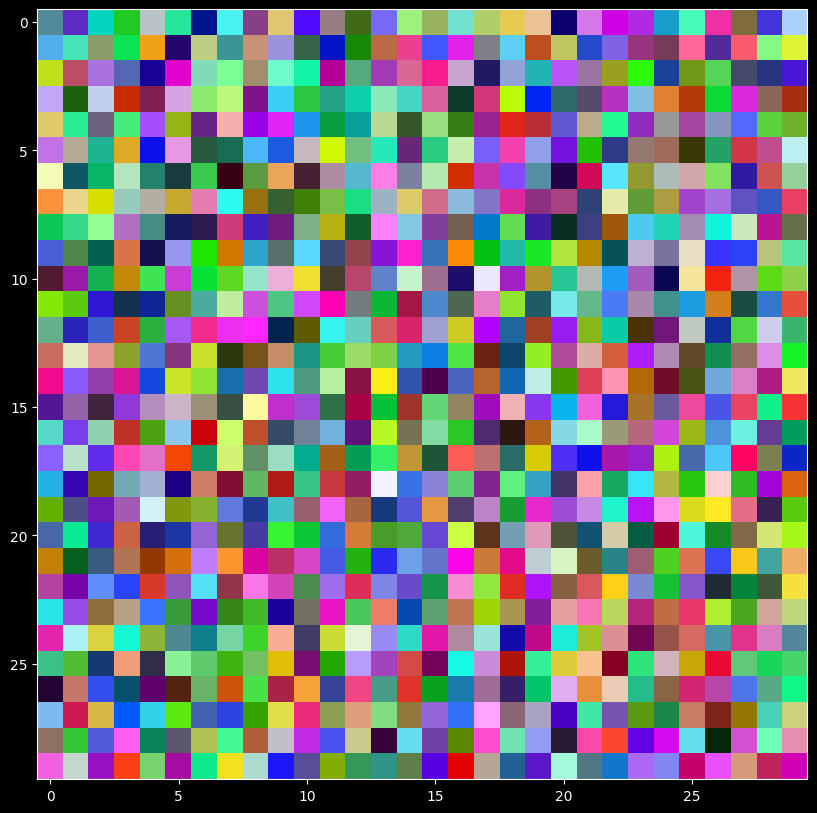

In [3]:
seed = 100
rng = np.random.default_rng(seed)
bgr = rng.integers(0, 256, size=(30,30,3), dtype=np.uint8)
plt.imshow(bgr[..., ::-1]);

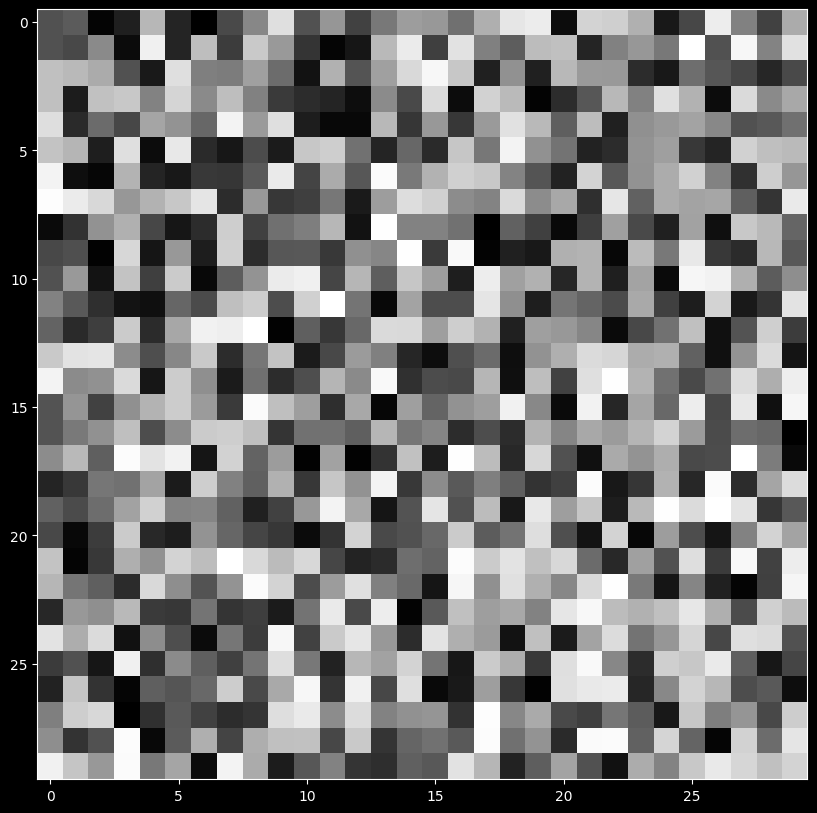

In [4]:
gray = bgr[..., -1]
plt.imshow(gray, cmap="gray", vmin=0, vmax=255);

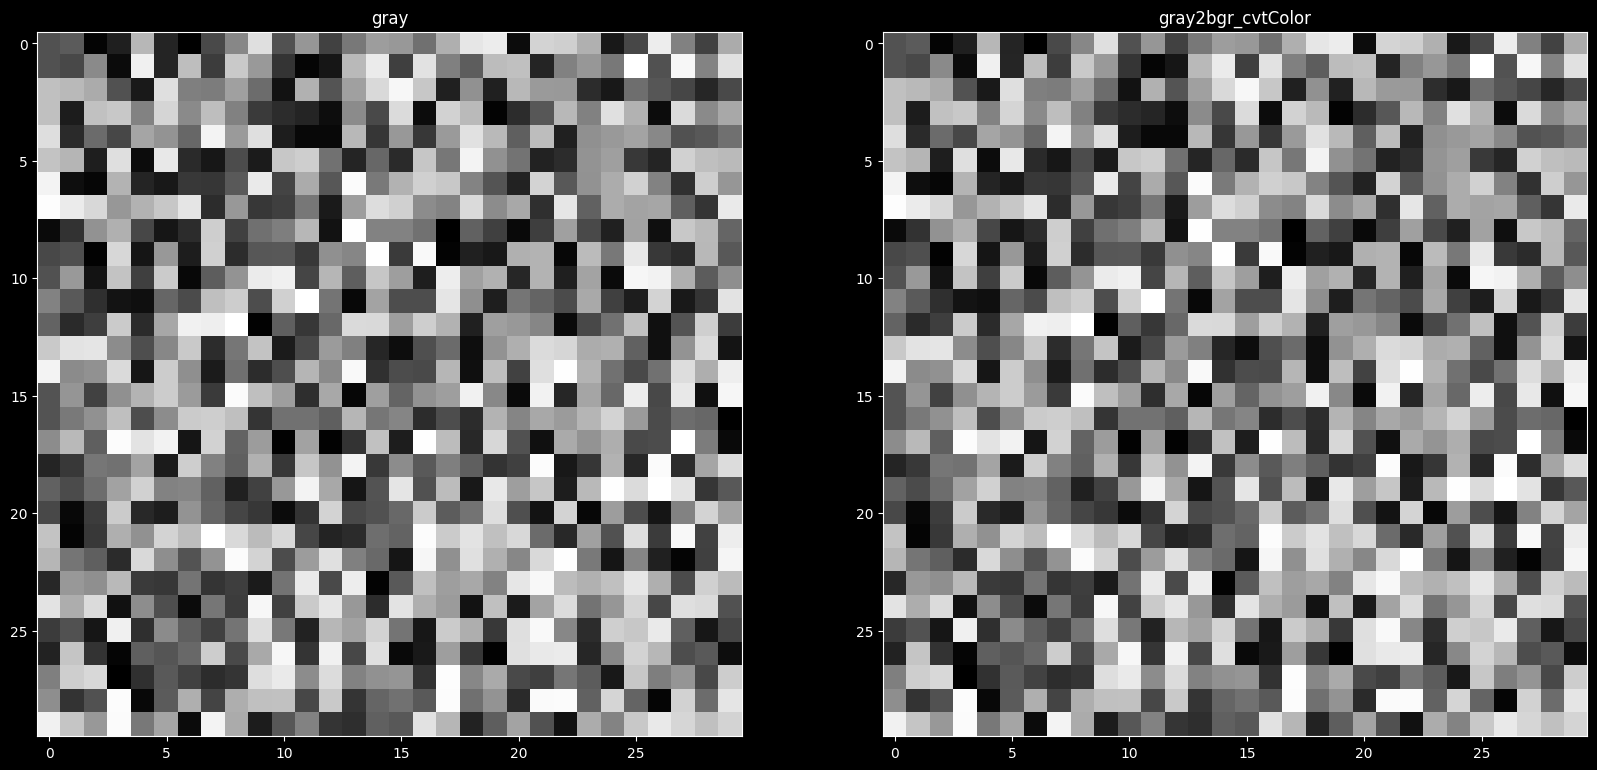

In [5]:
gray2bgr_cvtColor = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(gray, cmap="gray", vmin=0, vmax=255)
ax[1].imshow(gray2bgr_cvtColor[..., ::-1], vmin=0, vmax=255)
ax[0].set_title("gray")
ax[1].set_title("gray2bgr_cvtColor");

Well, we can say nothing more than a mere
> "`gray` and `gray2bgr_cvtColor` look similar"

by `imshow`ing them this way. But let's further look at `gray2bgr_repeat`:

In [6]:
gray2bgr_repeat = np.stack([gray]*3)
for i in range(3):
    print(np.array_equal(gray2bgr_repeat[..., i], gray))

False
False
False


In [7]:
gray2bgr_repeat.shape

(3, 30, 30)

Oops!

In [8]:
gray2bgr_repeat = np.stack([gray]*3, axis=-1)
gray2bgr_repeat.shape

(30, 30, 3)

In [9]:
for i in range(3):
    print(np.array_equal(gray2bgr_repeat[..., i], gray))

True
True
True


Great!

In [10]:
np.array_equal(gray2bgr_repeat, gray2bgr_cvtColor)

True

Imperically, we have shown that hypothesis 1 is **at least true for the one single example here.**

However, since the starting array `bgr` is a **random array**, we could somewhat retain confidence that hypothesis 1 is true in general.

## `np.stack`? Appropriate? Best?

Note that, in order to repeat the `gray` three times to fill into three channels, we have opted
to use the `np.stack` function. Did we create a copy this way? If that is the case, is there any
other way which allows us to create a view instead?

In [11]:
np.shares_memory(gray2bgr_repeat, gray)

False

In [12]:
np.shares_memory(gray2bgr_cvtColor, gray)

False

Yes, we have created copies, be it `gray2bgr_repeat` or `gray2bgr_cvtColor`.

**(?1)** Could we use `reshape`?  

In [13]:
import traceback

In [14]:
new_shape = (*gray.shape, 3)
print(f"{new_shape = }")
try:
    gray2bgr_reshape = gray.reshape(new_shape)
    print(f"{gray2bgr_reshape.shape}")
except:
    traceback.print_exc()

new_shape = (30, 30, 3)


Traceback (most recent call last):
  File "/var/folders/l5/gygxbwc52h1br846nd2ml9b0cnzszn/T/ipykernel_24440/904477296.py", line 4, in <cell line: 3>
    gray2bgr_reshape = gray.reshape(new_shape)
ValueError: cannot reshape array of size 900 into shape (30,30,3)


In [15]:
try:
    gray2bgr_broadcast = np.broadcast(gray, new_shape)
    print(f"{gray2bgr_broadcast.shape = }")
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/l5/gygxbwc52h1br846nd2ml9b0cnzszn/T/ipykernel_24440/2913884054.py", line 2, in <cell line: 1>
    gray2bgr_broadcast = np.broadcast(gray, new_shape)
ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (30, 30) and arg 1 with shape (3,).


**(R1)** Broadcast seems to require the extra dimensions to be `1`. That's why
both `reshape` and `np.broadcast` both fails.

Instead, One could make use of `np.lib.stride_tricks.as_strided`.
Cf. e.g. the following links for more info
- <https://numpy.org/doc/stable/reference/generated/numpy.ndarray.strides.html>
- <https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.as_strided.html>

In [16]:
gray.shape, gray.strides

((30, 30), (90, 3))

In [17]:
gray2bgr_stride = np.lib.stride_tricks.as_strided(
    gray,
    shape=new_shape,
    strides=(90,3,0),
)
gray2bgr_stride.shape

(30, 30, 3)

In [18]:
np.shares_memory(gray2bgr_stride, gray)

True

In [19]:
for i in range(3):
    print(np.array_equal(gray2bgr_stride[...,i], gray))

True
True
True


Let's time the creation of all the `gray2bgr`'s conceived so far. We expect `gray2bgr_stride` to be the fastest.

In [20]:
%timeit gray2bgr_cvtColor = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

3.58 µs ± 39.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [21]:
%timeit gray2bgr_repeat = np.stack([gray]*3)

9.92 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
%%timeit
gray2bgr_stride = np.lib.stride_tricks.as_strided(
    gray,
    shape=new_shape,
    strides=(90,3,0),
)

4.41 µs ± 43.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


> Unfortunately, the stride way is slower than `cv2.COLOR_GRAY2BGR`.  
> Or actually fortunately! Since we don't need to remember to use the somewhat complicated
> `np.lib.stride_tricks.as_strided`

But at least it's assuring that the stride way is faster than the `np.stack` way.

## OpenCV Source Code

I am not really a C++ programmer, but I think this [url](https://github.com/egonSchiele/OpenCV/blob/master/modules/imgproc/src/color.cpp#L292)
proves that `cv2.COLOR_GRAY2BGR` is really simply copying a grayscale image
to RGB channels.

```cpp
template<typename _Tp>
struct Gray2RGB
{
    typedef _Tp channel_type;
    
    Gray2RGB(int _dstcn) : dstcn(_dstcn) {}
    void operator()(const _Tp* src, _Tp* dst, int n) const
    {
        if( dstcn == 3 )
            for( int i = 0; i < n; i++, dst += 3 )
            {
                dst[0] = dst[1] = dst[2] = src[i];
            }
        else
        {
            _Tp alpha = ColorChannel<_Tp>::max();
            for( int i = 0; i < n; i++, dst += 4 )
            {
                dst[0] = dst[1] = dst[2] = src[i];
                dst[3] = alpha;
            }
        }
    }
    
    int dstcn;
};
```